In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [3]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""

    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        # 定义权重向量w。使用torch.normal以指定的均值（0）和标准差（sigma）生成形状为(num_inputs, 1)的正态分布随机数。
        # requires_grad=True表明w需要计算梯度，这对于后续的自动梯度计算（自动微分）是必要的。
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        # 生成(1,) 即1行维度的零向量，且只有一个值 1。requires_grad=True表明b需要计算梯度，这对于后续的自动梯度计算
        self.b = torch.zeros(1, requires_grad=True)

    def forward(self, X):
        #这个操作执行矩阵乘法，将输入数据X与权重self.w相乘。结果是每个样本的线性组合，形状为(n_samples, 1)，每个样本对应一个输出值。
        return torch.matmul(X, self.w) + self.b

    def loss(self, y_hat, y):
        # 预测值 - 真实值
        l = (y_hat - y)**2 / 2
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)

loss <class 'torch.Tensor'>


'\n1. 梯度累积\n首先，loss.backward()触发损失张量（loss）开始对其构成成分（通常是模型参数）的梯度进行自动计算。在反向传播的过程中，每个参数的梯度会被累积（即累加）到各自的.grad属性中。这是因为在训练过程中可能会多次反向传播而不更新参数（例如，在梯度累积场景中用于处理大批量数据），所以需要累积梯度。\n\n2. 链式法则\n反向传播利用链式法则来计算对于每个参数的损失函数的梯度。链式法则是微积分中的一个基本原则，用于计算复合函数的导数。在深度学习的上下文中，模型可以被看作是一系列函数的复合，其中每一层的输出都是下一层的输入。因此，损失相对于任何参数的梯度都可以通过从损失开始，逐层向后应用链式法则来计算。\n\n3. 梯度计算\n对于计算图中的每个节点（代表一个操作或函数），PyTorch都会计算该节点输出相对于其输入的梯度。这个过程从loss节点开始，沿着计算图向后遍历，直到达到图中的叶子节点，通常是模型的输入参数。在这个过程中，通过链式法则，可以计算出loss相对于这些叶子节点的梯度。\n\n4. 更新.grad属性\n计算出的梯度会被存储在对应叶子节点张量的.grad属性中。这意味着每个模型参数（权重和偏置）的梯度都会被计算并存储，准备用于后续的参数更新步骤。\n\n5. 清空之前的梯度（可选，但推荐）\n在进行下一次前向传播之前，通常需要手动将参数的.grad属性清零（例如，通过调用optimizer.zero_grad()或param.grad.zero_()）来避免梯度累积到下一个训练步骤中。这不是loss.backward()做的事情，但是是紧接着梯度计算步骤必须考虑的一个重要环节。\n\n通过这个过程，模型的每个参数都会有一个表示该次训练迭代中损失对它的影响程度的梯度，这为接下来的参数更新（比如使用SGD或Adam优化器）提供了必要的信息。\n'

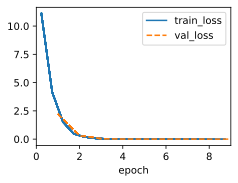

In [4]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    # 设置训练模式
    self.model.train()
    for batch in self.train_dataloader:
        # 计算损失
        loss = self.model.training_step(self.prepare_batch(batch))
        # 梯度归0
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            # 设置了梯度裁剪值（gradient_clip_val），则裁剪梯度。
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    # 设置为评估模式，并遍历验证数据进行评估
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1
    # 损失值类型 调试用
    print('loss', type(loss))

model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=9)
trainer.fit(model, data)

# loss.backward()
'''
1. 梯度累积
首先，loss.backward()触发损失张量（loss）开始对其构成成分（通常是模型参数）的梯度进行自动计算。在反向传播的过程中，每个参数的梯度会被累积（即累加）到各自的.grad属性中。这是因为在训练过程中可能会多次反向传播而不更新参数（例如，在梯度累积场景中用于处理大批量数据），所以需要累积梯度。

2. 链式法则
反向传播利用链式法则来计算对于每个参数的损失函数的梯度。链式法则是微积分中的一个基本原则，用于计算复合函数的导数。在深度学习的上下文中，模型可以被看作是一系列函数的复合，其中每一层的输出都是下一层的输入。因此，损失相对于任何参数的梯度都可以通过从损失开始，逐层向后应用链式法则来计算。

3. 梯度计算
对于计算图中的每个节点（代表一个操作或函数），PyTorch都会计算该节点输出相对于其输入的梯度。这个过程从loss节点开始，沿着计算图向后遍历，直到达到图中的叶子节点，通常是模型的输入参数。在这个过程中，通过链式法则，可以计算出loss相对于这些叶子节点的梯度。

4. 更新.grad属性
计算出的梯度会被存储在对应叶子节点张量的.grad属性中。这意味着每个模型参数（权重和偏置）的梯度都会被计算并存储，准备用于后续的参数更新步骤。

5. 清空之前的梯度（可选，但推荐）
在进行下一次前向传播之前，通常需要手动将参数的.grad属性清零（例如，通过调用optimizer.zero_grad()或param.grad.zero_()）来避免梯度累积到下一个训练步骤中。这不是loss.backward()做的事情，但是是紧接着梯度计算步骤必须考虑的一个重要环节。

通过这个过程，模型的每个参数都会有一个表示该次训练迭代中损失对它的影响程度的梯度，这为接下来的参数更新（比如使用SGD或Adam优化器）提供了必要的信息。
'''

In [5]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')
    
print(model.w)

error in estimating w: tensor([-7.5817e-05,  1.8740e-04])
error in estimating b: tensor([0.0004])
tensor([[ 2.0001],
        [-3.4002]], requires_grad=True)
